# **Projeto de Transfer Learning em Python**

### **Aluno: Guilherme Klemann**

##### Professor Instrutor: Diego Renan

O presente projeto é pré-requisito para a conclusão do módulo de Machine Learning, do Botcamp Geração Tech Unimed-BH - Ciência de Dados. O objetivo do projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.



Imports

In [1]:
%matplotlib inline

import os
import random
import numpy as np
import keras
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

from six.moves import urllib
import gzip

from shutil import copyfile

import matplotlib.image as img
from tensorflow import keras

Loading Data

In [2]:
!echo "Downloading catsanddogs for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip #download

# As instruÃƒÂ§ÃƒÂµes para preparar o conjunto de dados sÃƒÂ£o para Linux ou macOS

!unzip kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!ls

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/55

Loading and Clearing Data

In [3]:
print(len(os.listdir('/content/PetImages/Cat')))
print(len(os.listdir('/content/PetImages/Dog')))

12501
12501


In [4]:
try:
    os.mkdir('cats-v-dogs')
    os.mkdir('cats-v-dogs/training')
    os.mkdir('cats-v-dogs/testing')
    os.mkdir('cats-v-dogs/training/cats')
    os.mkdir('cats-v-dogs/training/dogs')
    os.mkdir('cats-v-dogs/testing/cats')
    os.mkdir('cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "PetImages/Cat/"
TRAINING_CATS_DIR = "cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "PetImages/Dog/"
TRAINING_DOGS_DIR = "cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('cats-v-dogs/training/cats/')))
print(len(os.listdir('cats-v-dogs/training/dogs/')))
print(len(os.listdir('cats-v-dogs/testing/cats/')))
print(len(os.listdir('cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [7]:
datasetdir = '/content/PetImages'
os.chdir(datasetdir)


# atalho para a classe ImageDataGenerator
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

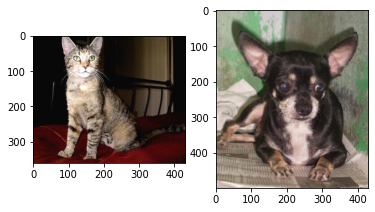

In [8]:
plt.subplot(1,2,1)
plt.imshow(img.imread('Cat/10000.jpg'))
plt.subplot(1,2,2)
plt.imshow(img.imread('Dog/10722.jpg'))

In [9]:
images = []
for i in range(10):
  im = img.imread('Cat/660.jpg'.format(i))
  images.append(im)
  print('image shape', im.shape, 'maximum color level', im.max())

image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255
image shape (346, 259, 4) maximum color level 255


In [10]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [11]:
gen = ImageDataGenerator()

In [12]:
iterator = gen.flow_from_directory(
    os.getcwd(), 
    target_size=(256,256), 
    classes=('Dog','Cat')
)


Found 25000 images belonging to 2 classes.


In [13]:
batch = iterator.next()
len(batch)

2

In [14]:
print(type(batch[0]))
print(type(batch[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [15]:
print(batch[0].shape)
print(batch[0].dtype)
print(batch[0].max())
print(batch[1].shape)
print(batch[1].dtype)

(32, 256, 256, 3)
float32
255.0
(32, 2)
float32


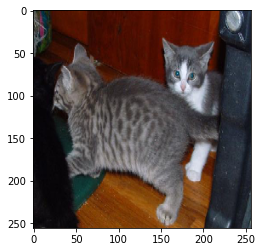

In [16]:
plt.imshow(batch[0][0].astype(int))

In [17]:
batch[1][0]

array([0., 1.], dtype=float32)

In [18]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 4,8
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img.astype(int))
      assert(label[0]+label[1]==1.)
      categ = 'Dog' if label[0]>0.5 else 'Cat'
      plt.title( '{} {}'.format(str(label), categ))
      plt.axis('off')

In [19]:
plot_images(iterator.next())

Output hidden; open in https://colab.research.google.com to view.

Training Data

In [20]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    validation_split = 0.2,
)

In [21]:
batch_size = 8
height, width = (256,256)

TRAINING_DIR = "/content/cats-v-dogs/training/"
train_dataset = imgdatagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'training'
)

VALIDATION_DIR = "/content/cats-v-dogs/testing/"
val_dataset = imgdatagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'validation'
)

Found 18000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [22]:
model = keras.models.Sequential()

initializers = {
    
}
model.add( 
    keras.layers.Conv2D(
        24, 5, input_shape=(256,256,3), 
        activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        48, 5, activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        96, 5, activation='relu', 
    )
)
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 24)      1824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 48)      28848     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 96)        115296    
                                                                 
 flatten (Flatten)           (None, 311904)            0

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=10,
)

Epoch 1/10
2083/2250 [==========================>...] - ETA: 2:33 - loss: 0.6398 - acc: 0.6239

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2250/2250 [==============================] - 2080s 923ms/step - loss: 0.6357 - acc: 0.6283 - val_loss: 0.5045 - val_acc: 0.7620
Epoch 2/10
2250/2250 [==============================] - 2027s 901ms/step - loss: 0.5310 - acc: 0.7337 - val_loss: 0.4887 - val_acc: 0.7600
Epoch 3/10
2250/2250 [==============================] - ETA: 0s - loss: 0.4567 - acc: 0.7889

In [ ]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [ ]:
plot_history(history, (0.65, 1.))

Data Increase

In [ ]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    horizontal_flip = True, 
    validation_split = 0.2,
)

In [ ]:
image = img.imread('Cat/100.jpg')

def plot_transform():
    '''apply the transformation 8 times randomly'''
    nrows, ncols = 2,4
    fig = plt.figure(figsize=(ncols*3, nrows*3), dpi=90)
    for i in range(nrows*ncols): 
        timage = imgdatagen.random_transform(image)
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(timage)
        plt.axis('off')
        
plot_transform()

In [ ]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    horizontal_flip = True, 
    zoom_range = 0.3, 
    rotation_range = 15.,
    validation_split = 0.1,
)

plot_transform()

In [ ]:
batch_size = 8
height, width = (256,256)

TRAINING_DIR = "/content/cats-v-dogs/training/"
train_dataset = imgdatagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'training'
)

VALIDATION_DIR = "/content/cats-v-dogs/testing/"
val_dataset = imgdatagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'validation'
)

In [ ]:
model = keras.models.Sequential()

initializers = {
    
}
model.add( 
    keras.layers.Conv2D(
        24, 5, input_shape=(256,256,3), 
        activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        48, 5, activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        96, 5, activation='relu', 
    )
)
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.2) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
history_augm = model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=40,
)

In [ ]:
plot_history(history_augm, (0.65, 1))

Export

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path